In [1]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

sys.path.append("..")
from utils.util_functions import *

pd.set_option('display.max_rows', 500)

In [2]:
#event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)
event_df = pd.read_csv(os.path.join(ROOT_DIR, "event_df.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2017 = make_df(end=1944417, data_dir=DETAIL_DATA_DIR_MLB)
df_2017 = pd.read_csv(os.path.join(ROOT_DIR, "df_2017.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2018 = make_df(start=1944417, data_dir=DETAIL_DATA_DIR_MLB)
df_2018 = pd.read_csv(os.path.join(ROOT_DIR, "df_2018.csv"), index_col=0, encoding="cp932", dtype=object)
files = os.listdir(DETAIL_DATA_DIR_MLB)[1:]
names = pd.Series(files).apply(lambda x: int(x.split(".")[0]))
files_2017 = names[names<=1944417].apply(lambda x: str(x)+".csv")
files_2018 = names[names>1944417].apply(lambda x: str(x)+".csv")
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")
first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']

In [3]:
def ranking(team):
    first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
    second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
    third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
    fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
    fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']
    lst = [first_teams, second_teams, third_teams, fourth_teams, fifth_teams]
    for i in range(len(lst)):
        teams = lst[i]
        if team in teams:
            return i + 1

In [4]:
case_expected_score_dict = dict(pd.read_csv(os.path.join(ROOT_DIR, "case_expected_score.csv"), dtype=object).values)
case_expected_score_dict = dict([[key, float(value)] for key, value in case_expected_score_dict.items()])

def weighted_score(case, score):
    """
    lst : (Stの状況, 直後の得点)
    """
    return score / case_expected_score_dict[case]

In [5]:
team = "Rソックス"
"""df = event_df[event_df.攻撃チーム==team]
triple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))
lst = make_flattened_list(triple)"""

'df = event_df[event_df.攻撃チーム==team]\ntriple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))\nlst = make_flattened_list(triple)'

In [6]:
def triple_on_score_diff(team, diff_lower, diff_upper):
    df = event_df[event_df.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))
    lst = make_flattened_list(triple)
    res = []
    for elem in lst:
        my_score = int(elem[1][1])
        opp_score = int(elem[1][2])
        if diff_lower < diff_upper:
            if diff_lower <= my_score - opp_score <= diff_upper:
                res.append(((elem[0][0], elem[0][1]), (elem[1][0], elem[1][1]), (elem[2][0], elem[2][1])))
        elif diff_lower > diff_upper:
            if diff_lower <= my_score - opp_score or my_score - opp_score <= diff_upper:
                res.append(((elem[0][0], elem[0][1]), (elem[1][0], elem[1][1]), (elem[2][0], elem[2][1])))
        else:
            raise "diff_lower == diff_upper"
    return res

## negative facilitation = 負けてることが逆に力になる

## negative facilitaitonを起こしがちなチームは、僅差で負けているとdet時の期待得点が上がる

# 点数気にしない

In [7]:
#imp_list = []
#det_list = []
res_dict1 = dict()
for team in teams_mlb:
    df = event_df[event_df.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="own"))
    lst = make_flattened_list(triple[:])
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    #imp_list.append(np.mean(improved_score_list))
    #det_list.append(np.mean(deteriorated_score_list))
    res_dict1[team] = (np.mean(improved_score_list), np.mean(deteriorated_score_list))
    print(team, np.mean(improved_score_list), np.mean(deteriorated_score_list))

パドレス 1.1194927535 0.895955108566
パイレーツ 1.35251383129 0.631483711265
マーリンズ 1.86824915894 0.800064418143
ヤンキース 1.82572305221 1.00319373951
カブス 1.12341609717 0.876937092662
アストロズ 1.92802262217 0.917786462583
タイガース 1.28639718647 0.715798861343
ナショナルズ 1.76014733489 0.813545986586
ツインズ 1.39918701953 0.842306335731
ロイヤルズ 2.20180326219 0.790367630575
メッツ 1.42374978819 0.962482221972
Rソックス 1.30982737849 0.819188972614
レンジャーズ 1.14533576548 0.970702274359
レイズ 0.889645129887 0.916170941551
アスレチックス 1.98687241498 1.08381309416
ジャイアンツ 0.882602478288 0.655131235304
ドジャース 1.91923638098 1.01325743801
ブリュワーズ 1.82942589581 0.946072698121
インディアンス 1.72810198903 1.01632508776
オリオールズ 1.86542104218 0.960262310013
マリナーズ 1.87008270554 0.902569233866
エンゼルス 1.20198645342 0.948968721226
ブルージェイズ 1.50872919605 1.01985066925
レッズ 1.40846019932 0.82715877444
Dバックス 1.80406127812 0.901758805464
Wソックス 2.08338100829 0.875830524006
ロッキーズ 1.88719126475 0.92113289828
フィリーズ 1.23471734456 0.783229856355
ブレーブス 1.27880759702 0.759

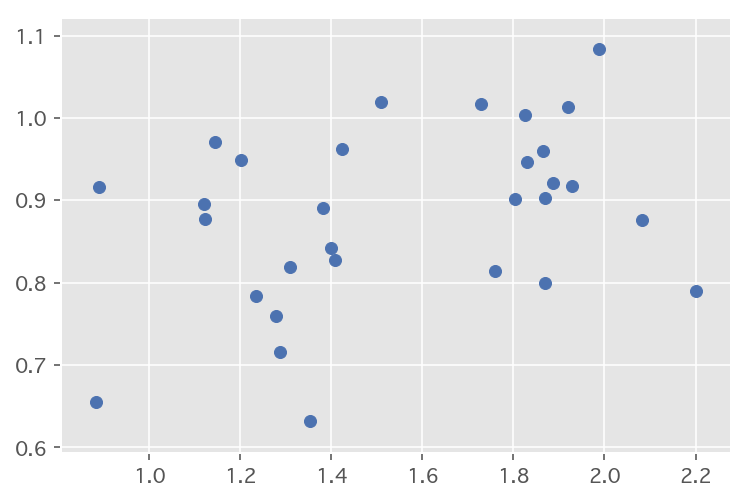

In [ ]:
plt.scatter([elem[0] for elem in list(res_dict1.values())], [elem[1] for elem in list(res_dict1.values())])

# 4点差の負け以内

In [ ]:
#imp_list = []
#det_list = []
res_dict = dict()
for team in teams_mlb:
    lst = triple_on_score_diff(team, -4, -1)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    #imp_list.append(np.mean(improved_score_list))
    #det_list.append(np.mean(deteriorated_score_list))
    res_dict[team] = (np.mean(improved_score_list), np.mean(deteriorated_score_list))
    print(team, np.mean(improved_score_list), np.mean(deteriorated_score_list))

パドレス 0.832459956564 0.971472514976
パイレーツ 1.102576444 0.553055526711
マーリンズ 1.46902107977 0.810571532113
ヤンキース 0.872290858787 0.801381620094
カブス 0.823479538951 0.717790584433
アストロズ 1.10091906223 0.963527010683
タイガース 1.32678225076 0.627972261624
ナショナルズ 0.632124223747 0.799143987202
ツインズ 1.23920773034 0.809332592573
ロイヤルズ 1.65828795187 0.993529597101
メッツ 1.20569790682 0.937853999983
Rソックス 1.54036348808 0.997019908432
レンジャーズ 0.765888576242 0.912531349195
レイズ 0.639373098359 0.958118230871
アスレチックス 1.95322400388 0.907319935113
ジャイアンツ 1.07878981595 0.561484314184
ドジャース 1.88395770939 1.03733382046
ブリュワーズ 1.344477634 0.94856045924


In [ ]:
plt.scatter([elem[0] for elem in list(res_dict.values())], [elem[1] for elem in list(res_dict.values())])

In [34]:
# 大差で勝っていると流れがいいとボコボコにするチーム
for team in teams_mlb:
    if res_dict1[team][1] < res_dict[team][1]:
        print(ranking(team), team, res_dict[team][0] - res_dict1[team][0])

Wソックス 4
マリナーズ 3
Rソックス 1
オリオールズ 5
ドジャース 1
ブルージェイズ 4
ブリュワーズ 1
アストロズ 1
アスレチックス 2
メッツ 4
ナショナルズ 2


In [36]:
for team in teams_mlb:
    if res_dict1[team] > res_dict[team]:
        print(team, ranking(team))

ロッキーズ 2
ツインズ 2
レッズ 5
インディアンス 1
パドレス 5
カージナルス 3
カブス 2
レンジャーズ 5
ジャイアンツ 4
フィリーズ 3
レイズ 3
エンゼルス 4
タイガース 3
ロイヤルズ 5
ヤンキース 2
ブレーブス 1
Dバックス 3
パイレーツ 4
マーリンズ 5
